# Distributing an arbitrarily shaped load onto a beam

Using `shapely` for 2D geometry

In [23]:
from __future__ import annotations
from typing import Optional
from shapely.wkt import load as load_wkt
from shapely.affinity import rotate
from shapely import Polygon, GeometryCollection, MultiPolygon
from dataclasses import dataclass
import itertools
from IPython.display import SVG
from rich import print

In [24]:
# These are helper functions required for other functions, below, to run

def get_slope_and_intercept(p0: tuple[float], p1: tuple[float]) -> tuple[float, float]:
    """
    Returns a tuple representing the slope and y-intercept of the line enclosing the
    line segment represented by the points 'p0' and 'p1'.

    p0 and p1 cannot describe a vertical line.
    """
    if not len(p0) == len(p1) == 2:
        return ValueError("Both p0 and p1 must be tuples of len == 2")
    x0, y0 = p0
    x1, y1 = p1
    slope = (y1 - y0) / (x1 - x0)
    y_intercept = y1 - slope * x1
    return slope, y_intercept


def get_range(ovlp: Overlap) -> tuple[float, float]:
    """
    Returns a tuple representing the values of y0 and y1 calculated
    from the information in 'ovlp' where y0 and y1 correlate with
    the locations of x0 and x1.
    """
    ya0 = ovlp.ma * ovlp.x0 + ovlp.ba
    ya1 = ovlp.ma * ovlp.x1 + ovlp.ba
    yb0 = ovlp.mb * ovlp.x0 + ovlp.bb
    yb1 = ovlp.mb * ovlp.x1 + ovlp.bb

    y0 = max(ya0, yb0) - min(ya0, yb0)
    y1 = max(ya1, yb1) - min(ya1, yb1)
    return y0, y1


def singularities_to_polygon(los: list[Singularity], xy: bool = False) -> Polygon:
    """
    Returns a Polygon in the shape of the singularity function.
    If 'xy' is True, function returns a list of x-coords and a list of y-coords
    """
    sorted_sings = sorted(los, key=lambda x: x.x1)
    x_acc = []
    prev_x = None
    n = None
    for idx, sing in enumerate(sorted_sings):
        n = sing.precision
        eps = 10**(-2*n)
        if prev_x != sing.x0 and prev_x is not None:
            x_acc.append(prev_x + eps)
        x_acc.append(sing.x0)
        x_acc.append(sing.x0 + eps)
        if idx == len(sorted_sings) - 1:
            x_acc.append(sing.x1 - eps)
        x_acc.append(sing.x1)
        prev_x = sing.x1
        if idx == len(sorted_sings) - 1: # Last iteration of actual iterations
            x_acc.append(sing.x1)

    x_acc = sorted(list(set(x_acc)))
    y_acc = [sum([sing(x) for sing in sorted_sings]) for x in x_acc[:-1]]
    # if len(y_acc) % 2 == 1:
    y_acc += [0.]
    if xy:
        return x_acc, y_acc
    else:
        precision = n if n else 2
        xy_acc = zip(
            [round(x, precision) for x in x_acc], 
            [round(y, precision) for y in y_acc]
            )
        
        return Polygon(xy_acc)


In [25]:
square_45 = Polygon([
    [0., 5.],
    [5., 10.],
    [10., 5.],
    [5., 0.,],
])

square_pac_man = Polygon([
    [0., 0.],
    [0., 10.],
    [10., 10.],
    [5., 5.,],
    [10., 0.,],
])

square_bow_tie = Polygon([
    [0., 0.],
    [4., 5.],
    [0., 10.],
    [10., 10.],
    [6., 5.,],
    [10., 0.,],
])

square_with_L_hole = Polygon([
    [0., 0.,],
    [0., 10.],
    [10., 10.,],
    [10., 0.],
], 
    holes = [[
    [2., 2.],
    [2., 8.],
    [8., 8.],
    [8., 6.],
    [4., 6.],
    [4., 2.],
]]
)

# Four Basic Test shapes

'square_45'

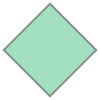

In [26]:
display("square_45", square_45)

'square_pac_man'

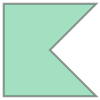

In [27]:
display("square_pac_man", square_pac_man)

'square_bow_tie'

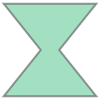

In [28]:
display("square_bow_tie", square_bow_tie)

'square_with_L_hole'

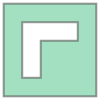

In [29]:
display("square_with_L_hole", square_with_L_hole)

# Overlap Regions

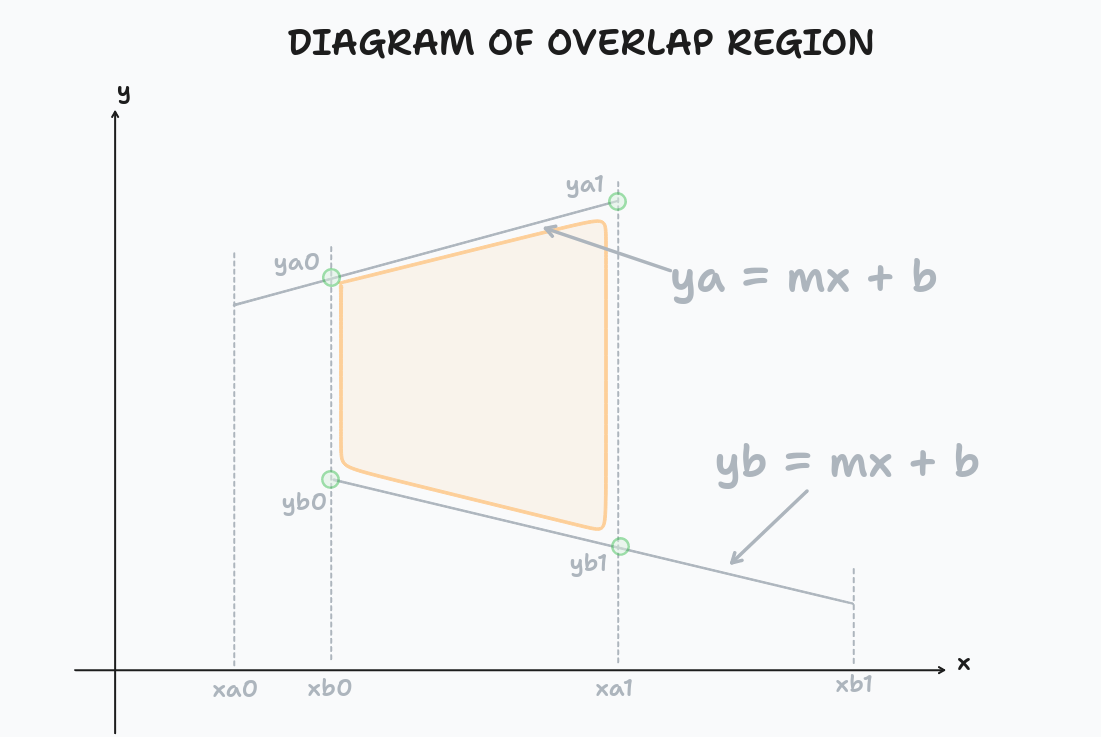

# `Overlap` data design

In [30]:
@dataclass
class Overlap:
    """
    Represents attributes of two line segments, a and b, that are one above the other,
    overlapping.
    Each line segment is defined by the following attributes representing
    each line as the equation y = mx + b
        x0, x1: starting and ending x coordinates
        m, b: slope and y-intercept
    """

    x0: float
    x1: float
    ma: float
    ba: float
    mb: float
    bb: float


# Examples
OL0 = Overlap(x0=-5.0, x1=10.0, ma=-4.0, ba=15.0, mb=2, bb=-2.0)
OL1 = Overlap(x0=12.3, x1=16.3, ma=0.5, ba=6.1, mb=-3.34, bb=2.5)

# Get Overlap Regions

### Using _three_ functions

In [31]:
def get_overlap_coords(
    xa0: float,
    xa1: float,
    xb0: float,
    xb1: float,
) -> Optional[tuple[float, float]]:
    """
    Returns a tuple representing the starting and ending x-coordinates of the region of overlap
    between two line segments, a and b, defined solely by each line segment's start and end
    x-coordinates, x0 and x1.

    If no overlap exists, None is returned.
    """
    # Five possible states captured by four conditions
    # (The fifth state is when the coordinates of xa and xb
    # are the same which will be captured by condition 3 and 4 but by
    # condition 3 first)
    
    overlap_coords = None
    if xa0 == xa1 or xb0 == xb1: # ignore vertical lines
        return overlap_coords
    # 1. Overlapping region with b "ahead" of a
    if xb0 < xa1 < xb1 and xa0 < xb0:
        overlap_coords = (xb0, xa1)
    # 2. Overlapping region with a "ahead" of b
    elif xb0 < xa0 < xb1 and xa1 > xb1:
        overlap_coords = (xa0, xb1)
    # 3. Overlapping region with a "inside" b
    elif xa0 >= xb0 and xa1 <= xb1:
        overlap_coords = (xa0, xa1)
    # 4. Overlapping region with b "inside" a
    elif xb0 >= xa0 and xb1 <= xa1:
        overlap_coords = (xb0, xb1)

    return overlap_coords

In [32]:
def get_overlap_region(
    pa0: tuple[float, float],
    pa1: tuple[float, float],
    pb0: tuple[float, float],
    pb1: tuple[float, float],
) -> Optional[Overlap]:
    """
    Returns an Overlap object representing the overlapping portion of the line
    segments a and b, represented by their respective points, p0 and p1.
    """
    xa0, _ = pa0
    xa1, _ = pa1
    xb0, _ = pb0
    xb1, _ = pb1
    xa0, xa1 = list(sorted([xa0, xa1]))
    xb0, xb1 = list(sorted([xb0, xb1]))

    overlapping_coords = get_overlap_coords(xa0, xa1, xb0, xb1)
    if overlapping_coords is None:
        return None
    a_slope, a_intercept = get_slope_and_intercept(pa0, pa1)
    b_slope, b_intercept = get_slope_and_intercept(pb0, pb1)
    x0 = min(overlapping_coords)
    x1 = max(overlapping_coords)
    overlap = Overlap(x0, x1, a_slope, a_intercept, b_slope, b_intercept)
    return overlap

In [33]:
def get_overlap_regions(
    p: Polygon, 
# ) -> list[Singularity]:
) -> list[Overlap]:
    """
    Returns a list of overlapping regions described by the vertices in the CONVEX polygon.
    The overlapping regions are described as a list of Singularity functions.
    """
    vertices = [vertex for vertex in p.exterior.coords]
    edge_indexes = [[k, k + 1] for k in range(len(vertices) - 1)]
    edge_combinations = itertools.combinations(edge_indexes, 2)
    overlapping_regions = []
    for edge_a, edge_b in edge_combinations:
        pa0_idx, pa1_idx = edge_a
        pb0_idx, pb1_idx = edge_b
        pa0, pa1 = vertices[pa0_idx], vertices[pa1_idx]
        pb0, pb1 = vertices[pb0_idx], vertices[pb1_idx]
        overlapping_region = get_overlap_region(
            pa0, pa1, pb0, pb1
        )
        if overlapping_region is None:
            continue
        overlapping_regions.append(overlapping_region)
        # singularity_function = overlap_region_to_singularity(overlapping_region)
        # overlapping_regions.append(singularity_function)
    return overlapping_regions

In [34]:
shape = square_with_L_hole
overlaps = get_overlap_regions(shape)
print(overlaps)

[Overlap(x0=0.0, x1=10.0, ma=0.0, ba=10.0, mb=-0.0, bb=0.0)]

# Get Void Regions

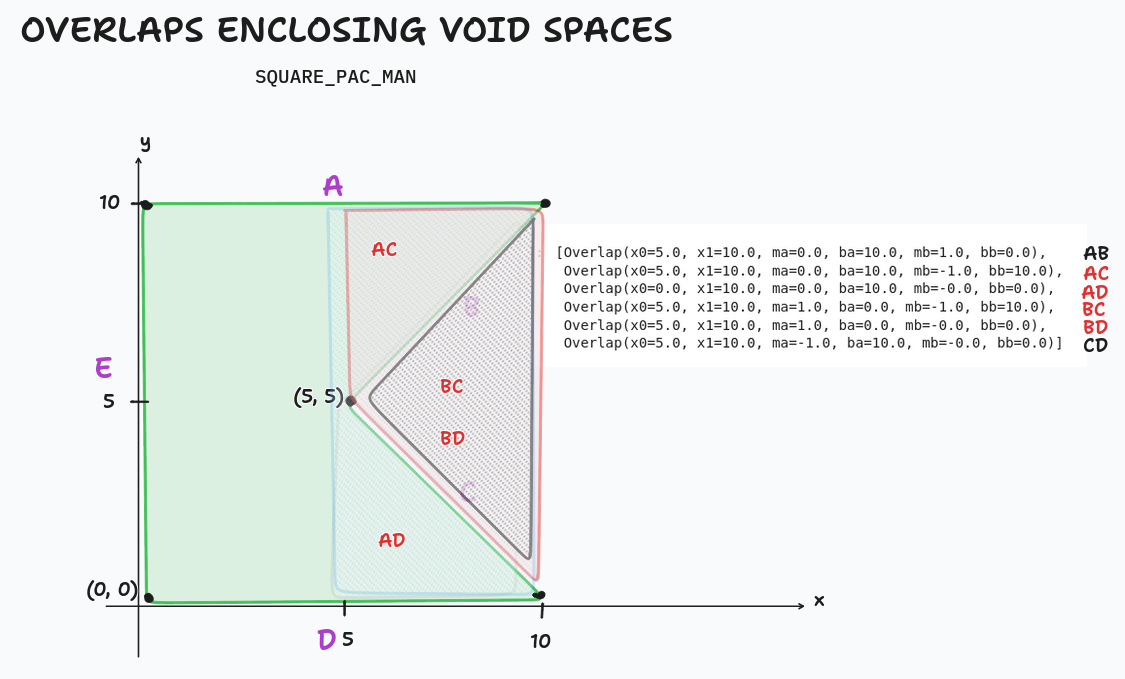

# Convex Hull

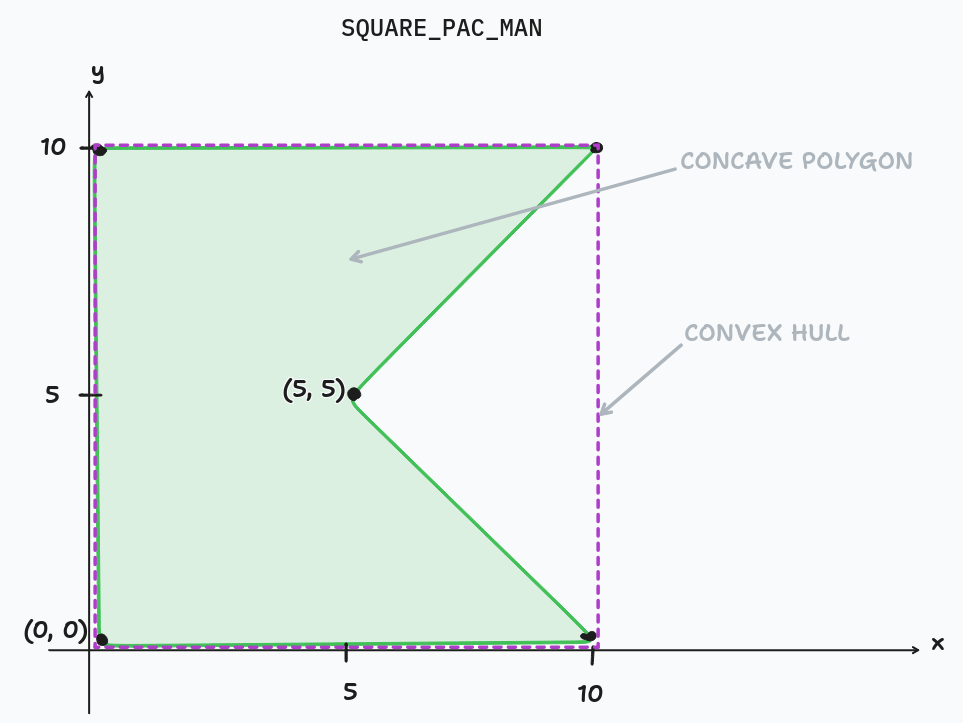

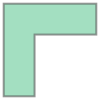

In [35]:
def get_void_regions(p: Polygon) -> list[Polygon]:
    """
    Returns the void regions as a list of Polygon, if any
    void regions exist within 'p'. If no void region is found,
    then an empty list is returned.

    A void region is defined as any region that does not lie
    within the convex hull of 'p'.
    """
    convex_hull = p.convex_hull
    void_regions = convex_hull - p
    if isinstance(void_regions, Polygon) and not void_regions.is_empty:
        return [void_regions]
    elif isinstance(void_regions, MultiPolygon):
        return list(void_regions.geoms)
    else:
        return []
    
shape = square_with_L_hole
voids = get_void_regions(shape)
GeometryCollection(voids)

# Overlaps to Singularity Functions

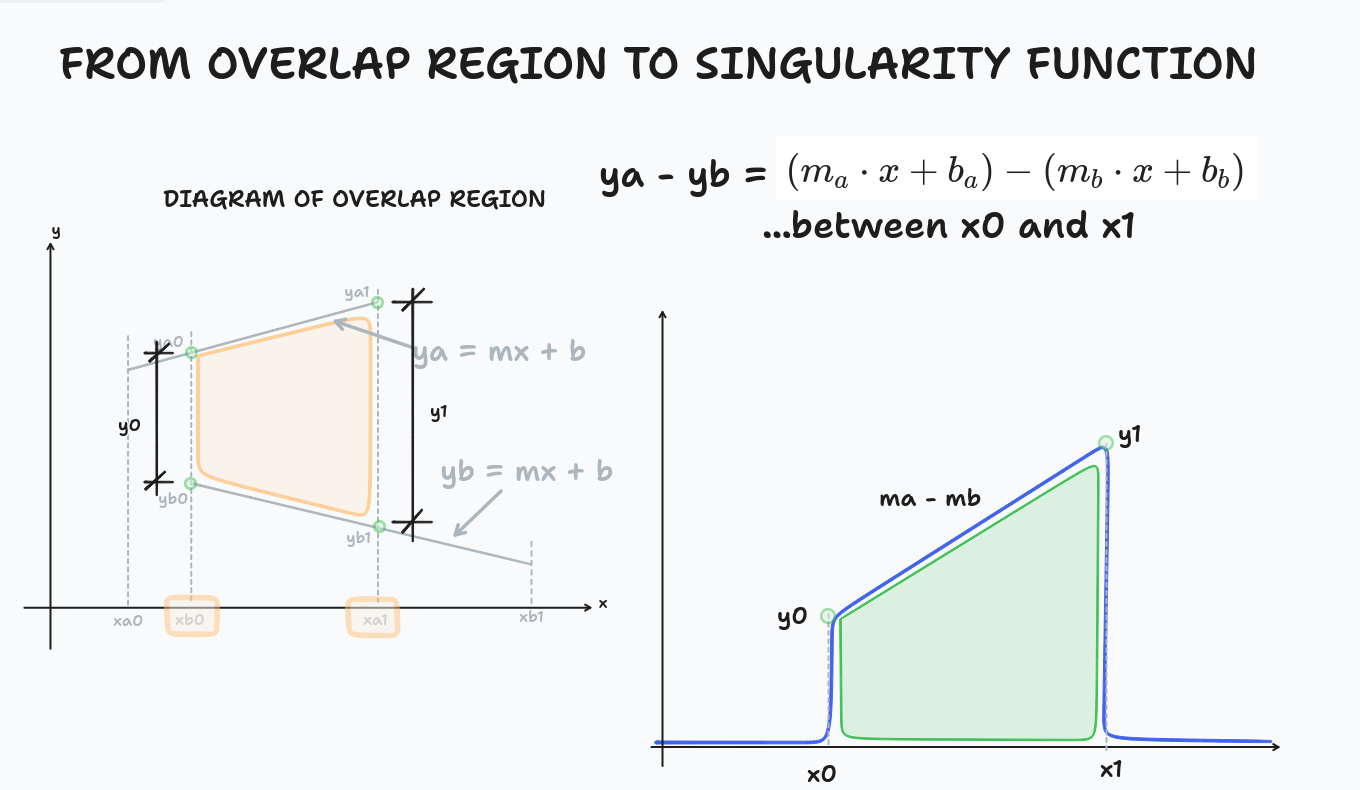

## `y1 = (x > x0) * (y0 + m * (x - x0)) * (x <= x1)`

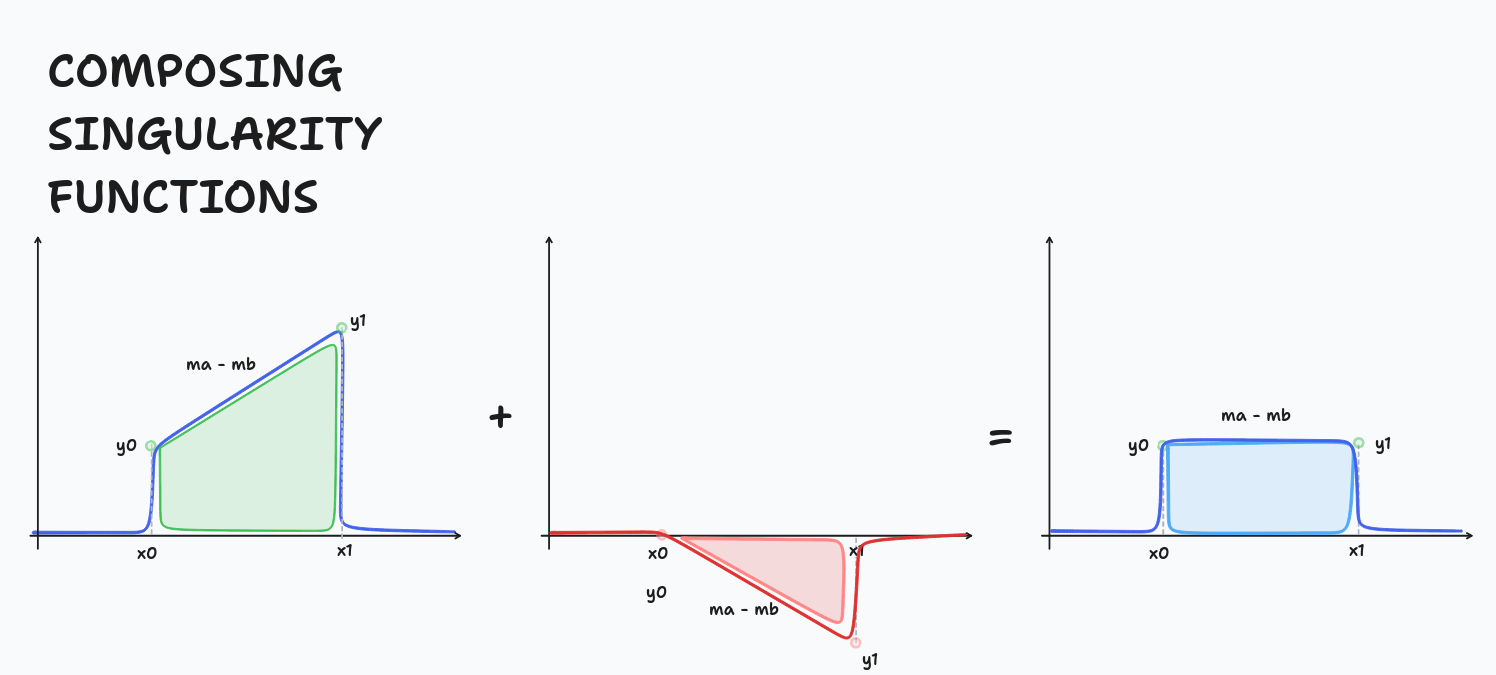

# `Singularity` data design

In [37]:
@dataclass
class Singularity:
    """
    Represents a singularity function with customizable attributes. The
    Singularity can be called like a function to generate a 'y' value
    from a given 'x' value.

    The singularity function is assumed to be linear and defined over a
    certain domain between x0 and x1, a slope of m, and with an initial
    y-value of y0. The resulting y-value for y1 will be rounded to
    'precision'.

    This class is defined as a callable class instead of as a function
    so that the attributes can be altered as required for appropriate
    scaling of the singularity function after it has been defined.
    """

    x0: float
    x1: float
    m: float
    y0: float
    precision: int

    def __call__(self, x: float) -> float:
        """
        Returns a value for 'y' calculated from 'x' and the attributes
        stored in the singularity function class instance.
        """
        y0 = self.y0
        x0 = self.x0
        x1 = self.x1
        m = self.m
        return round((x > x0) * (y0 + m * (x - x0)) * (x <= x1), self.precision)


    def __neg__(self):
        return Singularity(self.x0, self.x1, -self.m, -self.y0, self.precision)

## Converting `Overlap` to `Singularity`

In [38]:
def overlap_region_to_singularity(ovlp: Overlap, precision: int = 6) -> callable:
    """
    Returns a singularity function generated from 'ovlp'
    """
    y0, y1 = get_range(ovlp)
    x0 = ovlp.x0
    x1 = ovlp.x1
    m = (y1 - y0) / (x1 - x0)
    singularity_function = Singularity(x0, x1, m, y0, precision)
    return singularity_function

print(overlaps[0])
print(overlap_region_to_singularity(overlaps[0]))

Overlap(x0=0.0, x1=10.0, ma=0.0, ba=10.0, mb=-0.0, bb=0.0)

Singularity(x0=0.0, x1=10.0, m=0.0, y0=10.0, precision=6)

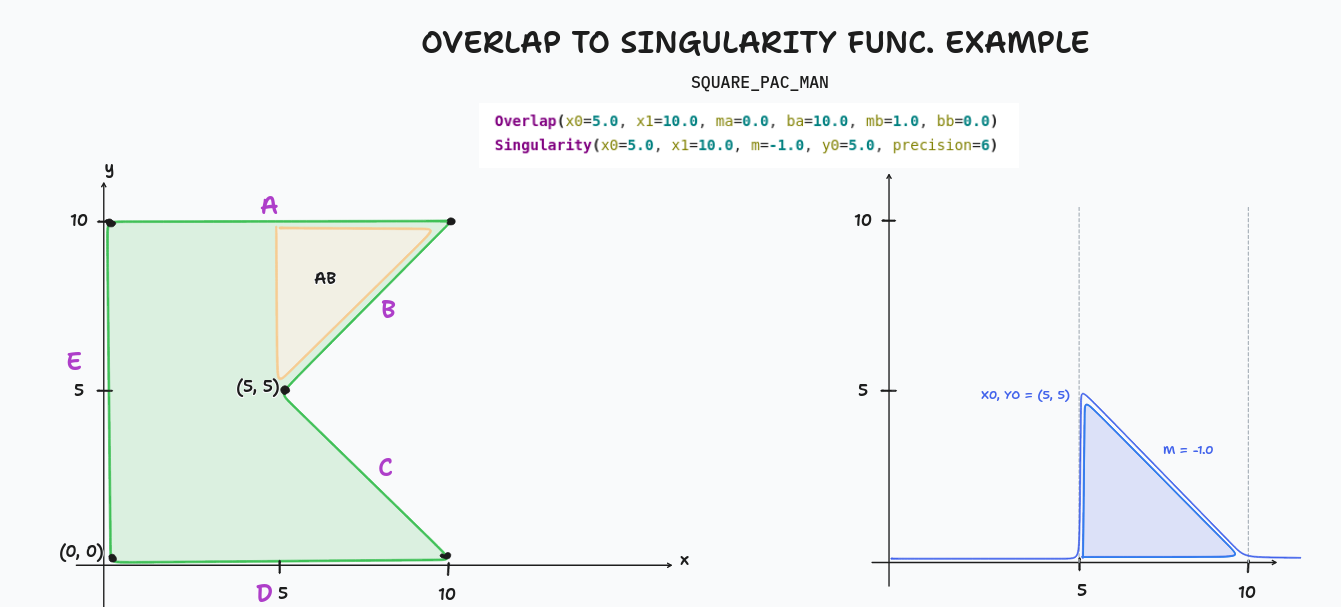

In [39]:
def get_overlap_regions(
    p: Polygon, 
    display_progress: bool = False
# ) -> list[Singularity]:
) -> list[Overlap]:
    """
    Returns a list of overlapping regions described by the vertices in the CONVEX polygon.
    The overlapping regions are described as a list of Singularity functions.
    """
    vertices = [vertex for vertex in p.exterior.coords]
    edge_indexes = [[k, k + 1] for k in range(len(vertices) - 1)]
    edge_combinations = itertools.combinations(edge_indexes, 2)
    overlapping_regions = []
    for edge_a, edge_b in edge_combinations:
        pa0_idx, pa1_idx = edge_a
        pb0_idx, pb1_idx = edge_b
        pa0, pa1 = vertices[pa0_idx], vertices[pa1_idx]
        pb0, pb1 = vertices[pb0_idx], vertices[pb1_idx]
        overlapping_region = get_overlap_region(
            pa0, pa1, pb0, pb1
        )
        if overlapping_region is None:
            continue
        # overlapping_regions.append(overlapping_region)
        singularity_function = overlap_region_to_singularity(overlapping_region)
        overlapping_regions.append(singularity_function)
    return overlapping_regions

# Singularity functions _from_ Polygon

In [40]:
def get_singularity_functions(p: Polygon, display_progress: bool = False) -> tuple[list[Singularity], list[Singularity]]:
    """
    Returns a 2-tuple, each element a list of Singularity. The first element is the overlapping regions
    of the convex hull of the polygon. The second element is the overlapping regions of the void spaces
    within the convex hull.
    """
    if p == p.convex_hull:
        return (get_overlap_regions(p), [])
    elif p.is_empty:
        return ([], [])
    else:
        void_regions = get_void_regions(p)
        convex_overlaps = get_overlap_regions(p.convex_hull)
        void_overlaps = []
        
        for void_region in void_regions:
            if void_region == void_region.convex_hull:
                void_overlaps += [-void_overlap for void_overlap in get_overlap_regions(void_region)]
            else:
                convex_voids, negative_voids = get_singularity_functions(void_region, display_progress)
                void_overlaps += [-void_overlap for void_overlap in convex_voids]
                void_overlaps += [-void_overlap for void_overlap in negative_voids]
    return (convex_overlaps, void_overlaps)

In [41]:
def get_singularity_functions(p: Polygon, display_progress: bool = False) -> tuple[list[Singularity], list[Singularity]]:
    """
    Returns a 2-tuple, each element a list of Singularity. The first element is the overlapping regions
    of the convex hull of the polygon. The second element is the overlapping regions of the void spaces
    within the convex hull.
    """
    if p == p.convex_hull:
        return (get_overlap_regions(p), [])
    elif p.is_empty:
        return ([], [])
    else:
        void_regions = get_void_regions(p)
        if display_progress:
            display("Void regions found:")
            display(MultiPolygon(void_regions))
        convex_overlaps = get_overlap_regions(p.convex_hull)
        void_overlaps = []
        for void_region in void_regions:
            if void_region == void_region.convex_hull:
                if display_progress:
                    display("Convex voids found:")
                    display(void_region)
                void_overlaps += [-void_overlap for void_overlap in get_overlap_regions(void_region)]
            else:
                convex_voids, negative_voids = get_singularity_functions(void_region, display_progress)
                if display_progress:
                    display("Non-convex voids found:")
                    display(void_region)
                    display("Convex hull of singularity function of void:")
                    display(singularities_to_polygon(convex_voids))
                    display("Removing singularity function of inner void:")
                    display(singularities_to_polygon(negative_voids))
                void_overlaps += [-void_overlap for void_overlap in convex_voids]
                void_overlaps += [-void_overlap for void_overlap in negative_voids]
    return (convex_overlaps, void_overlaps)

In [42]:
shape = square_45
singularities = get_singularity_functions(shape, display_progress=False)
# print(singularities)

# Singularity functions _to_ polygons

In [43]:
def singularities_to_polygon(los: list[Singularity], xy: bool = False) -> Polygon:
    """
    Returns a Polygon in the shape of the singularity function.
    If 'xy' is True, function returns a list of x-coords and a list of y-coords
    """
    sorted_sings = sorted(los, key=lambda x: x.x1)
    x_acc = []
    prev_x = None
    n = None
    for idx, sing in enumerate(sorted_sings):
        n = sing.precision
        eps = 10**(-2*n)
        if prev_x != sing.x0 and prev_x is not None:
            x_acc.append(prev_x + eps)
        x_acc.append(sing.x0)
        x_acc.append(sing.x0 + eps)
        if idx == len(sorted_sings) - 1:
            x_acc.append(sing.x1 - eps)
        x_acc.append(sing.x1)
        prev_x = sing.x1
        if idx == len(sorted_sings) - 1: # Last iteration of actual iterations
            x_acc.append(sing.x1)

    x_acc = sorted(list(set(x_acc)))
    y_acc = [sum([sing(x) for sing in sorted_sings]) for x in x_acc[:-1]]
    y_acc += [0.]
    if xy:
        return x_acc, y_acc
    else:
        precision = n if n else 2
        xy_acc = zip(
            [round(x, precision) for x in x_acc], 
            [round(y, precision) for y in y_acc]
            )
        
        return Polygon(xy_acc)

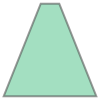

[(0.0, 0.0), (4.0, 10.0), (6.0, 10.0), (10.0, 0.0), (0.0, 0.0)]

In [47]:
shape = square_bow_tie
convex_sings, void_sings = get_singularity_functions(shape)

poly = singularities_to_polygon(convex_sings + void_sings)
display(poly)
# print(singularities_to_polygon(convex_sings + void_sings, xy=True))
print(list(poly.simplify(1).exterior.coords))